# Create Dataset

Generating dataset from freqtrade

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

2023-11-05 15:44:40.299012: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-05 15:44:40.328511: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-05 15:44:40.328540: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-05 15:44:40.328555: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-05 15:44:40.334561: I tensorflow/core/platform/cpu_feature_g

In [2]:
df = pd.read_pickle("btc_futures_ind25.pkl")

In [3]:
   df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105385 entries, 24 to 105408
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype              
---  ------                    --------------   -----              
 0   date                      105385 non-null  datetime64[ns, UTC]
 1   open                      105385 non-null  float64            
 2   high                      105385 non-null  float64            
 3   low                       105385 non-null  float64            
 4   close                     105385 non-null  float64            
 5   volume                    105385 non-null  float64            
 6   obv                       105385 non-null  float64            
 7   trend                     105385 non-null  float64            
 8   %-rsi-period              105384 non-null  float64            
 9   %-mfi-period              105384 non-null  float64            
 10  %-adx-period              105360 non-null  float64            
 11  %-sm

# Create datasets for Train, Validate, Test timeseries

## Split Dataset

In [4]:
# df.dropna(subset=['%-ema-period'], inplace=True)
# df.drop(['enter_long','enter_short','exit_long','exit_short'],axis=1,inplace=True) # may try dropping date in the future
df.drop(['open','high','close','low','%-raw_price','close','volume','trend'],axis=1,inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105385 entries, 24 to 105408
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype              
---  ------                    --------------   -----              
 0   date                      105385 non-null  datetime64[ns, UTC]
 1   obv                       105385 non-null  float64            
 2   %-rsi-period              105384 non-null  float64            
 3   %-mfi-period              105384 non-null  float64            
 4   %-adx-period              105360 non-null  float64            
 5   %-sma-period              105385 non-null  float64            
 6   %-ema-period              105385 non-null  float64            
 7   bb_lowerband-period       105385 non-null  float64            
 8   bb_middleband-period      105385 non-null  float64            
 9   bb_upperband-period       105385 non-null  float64            
 10  %-bb_width-period         105385 non-null  float64            
 11  %-cl

In [6]:
df.shape

(105385, 19)

In [7]:
df['&s-up_or_down'] = np.where(df['&s-up_or_down']=='up', 1, 0)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105385 entries, 24 to 105408
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype              
---  ------                    --------------   -----              
 0   date                      105385 non-null  datetime64[ns, UTC]
 1   obv                       105385 non-null  float64            
 2   %-rsi-period              105384 non-null  float64            
 3   %-mfi-period              105384 non-null  float64            
 4   %-adx-period              105360 non-null  float64            
 5   %-sma-period              105385 non-null  float64            
 6   %-ema-period              105385 non-null  float64            
 7   bb_lowerband-period       105385 non-null  float64            
 8   bb_middleband-period      105385 non-null  float64            
 9   bb_upperband-period       105385 non-null  float64            
 10  %-bb_width-period         105385 non-null  float64            
 11  %-cl

In [9]:
def split_data(dataframe, train_fraq, test_fraq):
    """Splits input series into train, val and test.
    train_fraq: decimal percentage fro train
    test_fraq: decimal percentage for test
    """
    # Get Dataframe series size
    size = df.shape[0]

    test_slice = int(size - size*test_fraq)
    test_data = dataframe.iloc[test_slice:]

    train_val_data = dataframe.iloc[:test_slice]

    #make train and validation from the remaining
    train_size = int(train_val_data.shape[0] * train_fraq)

    train_data = train_val_data.iloc[:train_size]
    val_data = train_val_data.iloc[train_size:]

    return train_data, val_data, test_data

In [10]:
train_data, val_data, test_data = split_data(df, 0.85, 0.15)

# Isolate Timestamp

train_time = train_data['date']
val_time = val_data['date']
test_time = test_data['date']

# Drop date from data

train_data.drop(['date'],axis=1,inplace=True)
val_data.drop(['date'],axis=1,inplace=True)
test_data.drop(['date'],axis=1,inplace=True)

/tmp/ipykernel_9275/298026112.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(['date'],axis=1,inplace=True)


In [11]:
test_time.info()

<class 'pandas.core.series.Series'>
Index: 15808 entries, 89601 to 105408
Series name: date
Non-Null Count  Dtype              
--------------  -----              
15808 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1)
memory usage: 247.0 KB


In [12]:
# Parameters
window_size = 25 #&s-up_or_down was classified based on 25 candles cycle
batch_size = 16
shuffle_buffer_size = 1000

In [13]:
dataset = tf.data.Dataset.from_tensor_slices(train_data)
dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

2023-11-05 15:45:18.183817: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-05 15:45:18.187856: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-05 15:45:18.187892: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-05 15:45:18.191596: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-05 15:45:18.191638: I tensorflow/compile

In [14]:
for element in dataset:
  print(list(element.as_numpy_iterator()))
  print(len(list(element.as_numpy_iterator())))
  break

[array([ 7.83117000e+02,             nan,             nan,             nan,
        2.34187040e+04,  2.34187040e+04,  2.33362530e+04,  2.34171053e+04,
        2.34979577e+04,  6.90540866e-03,  1.00495568e+00,             nan,
        6.60121000e-01, -3.49529627e-04,  8.04001000e+02,  3.00000000e+00,
        2.00000000e+00,  0.00000000e+00]), array([2.08410800e+03, 5.96630642e+01, 5.36628242e+01,            nan,
       2.34235680e+04, 2.34230806e+04, 2.33460464e+04, 2.34224333e+04,
       2.34988203e+04, 6.52254496e-03, 1.00554927e+00, 5.20681682e-01,
       1.08809441e+00, 1.01057910e-03, 1.30099100e+03, 3.00000000e+00,
       2.00000000e+00, 0.00000000e+00]), array([ 1.43366200e+03,  5.90956198e+01,  4.72210131e+01,             nan,
        2.34262480e+04,  2.34266744e+04,  2.33474778e+04,  2.34254547e+04,
        2.35034315e+04,  6.65744710e-03,  1.00523920e+00,  2.86290529e-01,
        5.91861382e-01, -2.47065038e-04,  6.50446000e+02,  3.00000000e+00,
        2.00000000e+00,  0.0000

2023-11-05 15:45:19.168077: W tensorflow/core/framework/dataset.cc:959] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


In [15]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to average
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples of features and labels. Lables used as 18 corresponds to &s-up_or_down
    dataset = dataset.map(lambda window: (window[:-1], window[18][-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [16]:
train_set = windowed_dataset(train_data, window_size, batch_size, shuffle_buffer_size)
val_set = windowed_dataset(val_data, window_size, batch_size, shuffle_buffer_size)
test_set = windowed_dataset(test_data, window_size, batch_size, shuffle_buffer_size)


for element, elemental in train_set:
  print(list(element.as_numpy_iterator()))
  print(len(list(element.as_numpy_iterator())))
  break

In [17]:
for element, elemental in train_set:
  print(element.shape)
  print(elemental.shape)
  break

(16, 25, 18)
(16,)


In [18]:
for idx,(x,y) in enumerate(train_set):
    print("x = ", x.numpy())
    print("x = ", x.numpy().shape)
    print("y = ", y.numpy())
    print("y = ", y.numpy().shape)
    break

x =  [[[-1.77981376e+05  4.90524618e+01  2.74872012e+01 ...  5.00000000e+00
    1.00000000e+01  1.00000000e+00]
  [-1.81088318e+05  4.17238224e+01  2.59070874e+01 ...  5.00000000e+00
    1.00000000e+01  1.00000000e+00]
  [-1.79713788e+05  4.76688859e+01  3.09048442e+01 ...  5.00000000e+00
    1.00000000e+01  1.00000000e+00]
  ...
  [-1.74000500e+05  5.27270106e+01  5.69599103e+01 ...  5.00000000e+00
    1.10000000e+01  1.00000000e+00]
  [-1.74598953e+05  5.16975065e+01  5.46391306e+01 ...  5.00000000e+00
    1.10000000e+01  1.00000000e+00]
  [-1.72659136e+05  5.29407816e+01  5.85816205e+01 ...  5.00000000e+00
    1.20000000e+01  1.00000000e+00]]

 [[-2.50649200e+03  3.31346556e+01  3.61857535e+01 ...  3.00000000e+00
    1.60000000e+01  0.00000000e+00]
  [-3.99726700e+03  3.24483444e+01  3.28306288e+01 ...  3.00000000e+00
    1.60000000e+01  1.00000000e+00]
  [-1.37526500e+03  3.80829781e+01  3.37275398e+01 ...  3.00000000e+00
    1.60000000e+01  1.00000000e+00]
  ...
  [-1.64865900e+03

In [19]:
# Get the first batch of the test dataset
batch_of_features, batch_of_labels = next((iter(test_set)))

print(f"batch_of_features has type: {type(batch_of_features)}\n")
print(f"batch_of_labels has type: {type(batch_of_labels)}\n")
print(f"batch_of_features has shape: {batch_of_features.shape}\n")
print(f"batch_of_labels has shape: {batch_of_labels.shape}\n")
#print(f"batch_of_features is equal to first five elements in the series: {np.allclose(batch_of_features.numpy().flatten(), train_set[:5])}\n")
#print(f"batch_of_labels is equal to first five labels: {np.allclose(batch_of_labels.numpy(), train_set[1:6])}")

batch_of_features has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_labels has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_features has shape: (16, 25, 18)

batch_of_labels has shape: (16,)



In [20]:
def compute_metrics(true_series, forecast):

    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

In [21]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)


## Plot Baseline

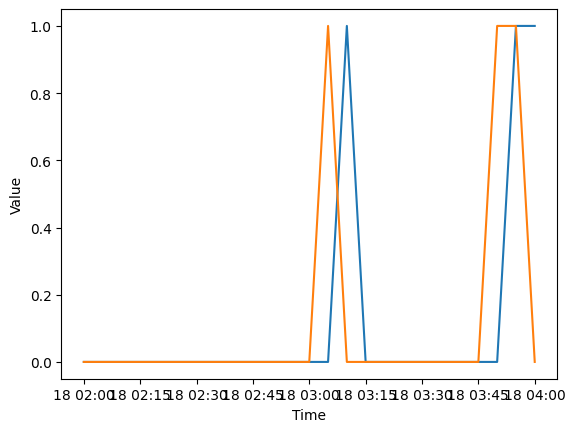

In [22]:
window = 25
plot_series(train_time[:window], train_data['&s-up_or_down'].iloc[:window])
plot_series(train_time[:window], train_data['&s-up_or_down'].shift(-1).iloc[:window])

In [23]:
mse, mae = compute_metrics(train_data['&s-up_or_down'].iloc[:window], train_data['&s-up_or_down'].shift(-1).iloc[:window])

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

2023-11-05 15:45:55.223289: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


mse: 0.16, mae: 0.16 for forecast


In [24]:
cce = tf.keras.losses.CategoricalCrossentropy()
cce(train_data['&s-up_or_down'].iloc[:window],train_data['&s-up_or_down'].shift(-1).iloc[:window]).numpy()

33.334803590584755

In [25]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
bce(train_data['&s-up_or_down'].iloc[:window],train_data['&s-up_or_down'].shift(-1).iloc[:window]).numpy()

2.4679917552847943

## Create Model Architecture

In [26]:
def create_model(window_size=25):

    ### START CODE HERE

    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(25, input_shape=[16, window_size, window_size], activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(10)
    ])

    # model.compile(loss='mse',
    #               optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9))

    model.compile(optimizer = 'rmsprop',
                loss = 'binary_crossentropy',
                metrics=['accuracy'])

    ### END CODE HERE
    model.summary()

    return model

In [27]:
def dnn_model(n_steps, n_horizon, n_features, lr):
    tf.keras.backend.clear_session()

    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(n_steps, n_features)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon, activation='sigmoid')
    ], name='dnn')

    # loss=tf.keras.losses.Huber()
    # optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    # model.compile(loss=loss, optimizer='adam', metrics=['mae'])

    # model.compile(loss='mse',
    #               optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9))

    model.compile(optimizer = 'rmsprop',
                loss = 'binary_crossentropy',
                metrics=['accuracy'])

    return model

In [28]:
def uncompiled_dnn_model(n_steps, n_horizon, n_features, lr):
    tf.keras.backend.clear_session()

    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(n_steps, n_features)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon, activation='sigmoid')
    ], name='dnn')

    # loss=tf.keras.losses.Huber()
    # optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    # model.compile(loss=loss, optimizer='adam', metrics=['mae'])

    # model.compile(loss='mse',
    #               optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9))

    # model.compile(optimizer = 'rmsprop',
    #             loss = 'sparse_categorical_crossentropy',
    #             metrics=['accuracy'])

    return model

In [29]:
# Test your uncompiled model

# Create an instance of the model
uncompiled_model = uncompiled_dnn_model(25,1,18,1e-4)
# Get one batch of the training set(X = input, y = label)
for X, y in train_set.take(1):

    # Generate a prediction
    print(f'Testing model prediction with input of shape {X.shape}...')
    y_pred = uncompiled_model.predict(X)

# Compare the shape of the prediction and the label y (remove dimensions of size 1)
y_pred_shape = y_pred.squeeze().shape

assert y_pred_shape == y.shape, (f'Squeezed predicted y shape = {y_pred_shape} '
                                           f'whereas actual y shape = {y.shape}.')

print("Your current architecture is compatible with the windowed dataset! :)")

Testing model prediction with input of shape (16, 25, 18)...
1/1 [==============================] - 5s 5s/step
Your current architecture is compatible with the windowed dataset! :)


In [30]:
dnn = dnn_model(25,1,18,1e-4)
dnn.summary()

Model: "dnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 450)               0         
                                                                 
 dense (Dense)               (None, 128)               57728     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0       

In [31]:
# tf.keras.utils.plot_model(dnn, show_shapes=True)

In [34]:
def adjust_learning_rate(dataset):

    model = uncompiled_dnn_model(25,1,18,1e-4)

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

    ### START CODE HERE

    # Select your optimizer
    optimizer = tf.keras.optimizers.SGD(momentum=0.9)

    # Compile the model passing in the appropriate loss
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=["accuracy"])

    ### END CODE HERE

    history = model.fit(dataset, epochs=10, callbacks=[lr_schedule])

    return history

In [35]:
lr_history = adjust_learning_rate(train_set)

Epoch 1/10
4758/4758 [==============================] - 22s 5ms/step - loss: nan - accuracy: 0.4993 - lr: 1.0000e-04
Epoch 2/10
  13/4758 [..............................] - ETA: 20s - loss: nan - accuracy: 0.5817 

2023-11-05 15:53:49.103226: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11389412194250751471
2023-11-05 15:53:49.103354: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 17754173917386972865
2023-11-05 15:53:49.103362: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3732071358994373762


4758/4758 [==============================] - 20s 4ms/step - loss: nan - accuracy: 0.4994 - lr: 1.1220e-04
Epoch 3/10
4758/4758 [==============================] - 20s 4ms/step - loss: nan - accuracy: 0.4994 - lr: 1.2589e-04
Epoch 4/10
4758/4758 [==============================] - 20s 4ms/step - loss: nan - accuracy: 0.4994 - lr: 1.4125e-04
Epoch 5/10
4758/4758 [==============================] - 21s 4ms/step - loss: nan - accuracy: 0.4994 - lr: 1.5849e-04
Epoch 6/10
4758/4758 [==============================] - 20s 4ms/step - loss: nan - accuracy: 0.4994 - lr: 1.7783e-04
Epoch 7/10
4758/4758 [==============================] - 20s 4ms/step - loss: nan - accuracy: 0.4994 - lr: 1.9953e-04
Epoch 8/10
4758/4758 [==============================] - 21s 4ms/step - loss: nan - accuracy: 0.4994 - lr: 2.2387e-04
Epoch 9/10
4758/4758 [==============================] - 20s 4ms/step - loss: nan - accuracy: 0.4994 - lr: 2.5119e-04
Epoch 10/10
4758/4758 [==============================] - 20s 4ms/step - los

(0.0001, 10.0, 0.0, 10.0)

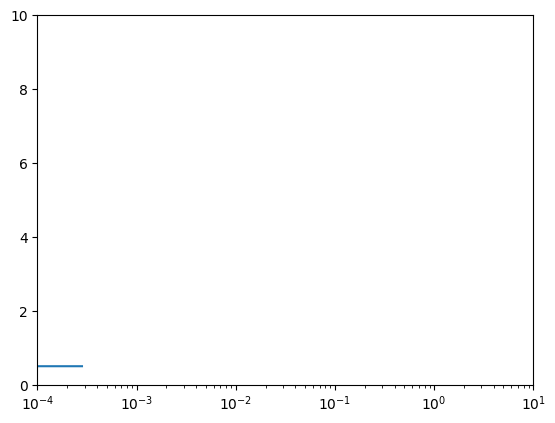

In [37]:
plt.semilogx(lr_history.history["lr"], lr_history.history["accuracy"])
plt.axis([1e-4, 10, 0, 10])

In [ ]:
dnn.fit(train_set, verbose=1, epochs=10, validation_data=val_set)

Epoch 1/10
4758/4758 [==============================] - 36s 7ms/step - loss: nan - accuracy: 0.4993 - val_loss: nan - val_accuracy: 0.4926
Epoch 2/10
4758/4758 [==============================] - 37s 8ms/step - loss: nan - accuracy: 0.4994 - val_loss: nan - val_accuracy: 0.4926
Epoch 3/10
4758/4758 [==============================] - 34s 7ms/step - loss: nan - accuracy: 0.4994 - val_loss: nan - val_accuracy: 0.4926
Epoch 4/10
4758/4758 [==============================] - 32s 7ms/step - loss: nan - accuracy: 0.4994 - val_loss: nan - val_accuracy: 0.4926
Epoch 5/10
4758/4758 [==============================] - 32s 7ms/step - loss: nan - accuracy: 0.4994 - val_loss: nan - val_accuracy: 0.4926
Epoch 6/10
4758/4758 [==============================] - 34s 7ms/step - loss: nan - accuracy: 0.4994 - val_loss: nan - val_accuracy: 0.4926
Epoch 7/10
4758/4758 [==============================] - 32s 7ms/step - loss: nan - accuracy: 0.4994 - val_loss: nan - val_accuracy: 0.4926
Epoch 8/10
4758/4758 [=====

In [ ]:
def cnn_model(n_steps, n_horizon, n_features, lr):
    tf.keras.backend.clear_session()

    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(64, kernel_size=6, activation='relu', input_shape=(n_steps,n_features)),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name="CNN")


    # loss=tf.keras.losses.Huber()
    # optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    # model.compile(loss=loss, optimizer='adam', metrics=['mae'])

    # model.compile(loss='mse',
    #               optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9))

    model.compile(optimizer = 'rmsprop',
                loss = 'binary_crossentropy',
                metrics=['accuracy'])

    return model

In [ ]:
cnn = cnn_model(25,1,18,1e-4)
cnn.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 64)            6976      
                                                                 
 max_pooling1d (MaxPooling1  (None, 10, 64)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 8, 64)             12352     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 4, 64)             0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0       

In [ ]:
cnn.fit(train_set, verbose=1, epochs=10, validation_data=val_set)

Epoch 1/10
4758/4758 [==============================] - 40s 8ms/step - loss: nan - accuracy: 0.4994 - val_loss: nan - val_accuracy: 0.4926
Epoch 2/10
4758/4758 [==============================] - 34s 7ms/step - loss: nan - accuracy: 0.4994 - val_loss: nan - val_accuracy: 0.4926
Epoch 3/10
4758/4758 [==============================] - 36s 7ms/step - loss: nan - accuracy: 0.4994 - val_loss: nan - val_accuracy: 0.4926
Epoch 4/10
4758/4758 [==============================] - 35s 7ms/step - loss: nan - accuracy: 0.4994 - val_loss: nan - val_accuracy: 0.4926
Epoch 5/10
4758/4758 [==============================] - 36s 8ms/step - loss: nan - accuracy: 0.4994 - val_loss: nan - val_accuracy: 0.4926
Epoch 6/10
4758/4758 [==============================] - 36s 7ms/step - loss: nan - accuracy: 0.4994 - val_loss: nan - val_accuracy: 0.4926
Epoch 7/10
2646/4758 [===============>..............] - ETA: 16s - loss: nan - accuracy: 0.5052

KeyboardInterrupt: ignored

In [38]:
def lstm_model(n_steps, n_horizon, n_features, lr):
    tf.keras.backend.clear_session()

    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(72, activation='relu', input_shape=(n_steps, n_features), return_sequences=True),
        tf.keras.layers.LSTM(48, activation='relu', return_sequences=False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name='lstm')


    # loss=tf.keras.losses.Huber()
    # optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    # model.compile(loss=loss, optimizer='adam', metrics=['mae'])

    # model.compile(loss='mse',
    #               optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9))

    model.compile(optimizer = 'rmsprop',
                loss = 'binary_crossentropy',
                metrics=['accuracy'])

    return model

In [ ]:
lstm = lstm_model(25,1,18,1e-4)
lstm.summary()
lstm.fit(train_set, verbose=1, epochs=10, validation_data=val_set)

In [49]:
from tensorflow.keras.layers import Layer
from tensorflow.keras.initializers import RandomUniform

class BinaryStochasticLayer(tf.keras.layers.Layer):
    def __init__(self, num_neurons, **kwargs):
        super(BinaryStochasticLayer, self).__init__(**kwargs)
        self.num_neurons = num_neurons

    def build(self, input_shape):
        self.kernels = []
        for _ in range(self.num_neurons):
            kernel = self.add_weight("kernel", shape=input_shape[1:], initializer=RandomUniform(0, 1), trainable=True)
            self.kernels.append(kernel)
        super(BinaryStochasticLayer, self).build(input_shape)

    def call(self, inputs):
        stochastic_activations = []
        for kernel in self.kernels:
            stochastic_activation = tf.random.uniform(tf.shape(inputs)) < kernel
            stochastic_activations.append(stochastic_activation)
        return tf.concat(stochastic_activations, axis=-1)

In [50]:
def binary_model(n_steps, n_horizon, n_features, lr):
    tf.keras.backend.clear_session()

    model = tf.keras.models.Sequential(name='lstm-binary')

    
    # Add the rest of the layers
    model.add(tf.keras.layers.LSTM(72, activation='relu', return_sequences=True))
    model.add(tf.keras.layers.LSTM(48, activation='relu', return_sequences=False))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.3))

    # Insert the BinaryStochasticNeuron layer at the beginning
    model.add(BinaryStochasticLayer(128, input_shape=(n_steps, n_features)))
    #model.add(Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(n_horizon))
    


    # loss=tf.keras.losses.Huber()
    # optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    # model.compile(loss=loss, optimizer='adam', metrics=['mae'])

    # model.compile(loss='mse',
    #               optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9))

    model.compile(optimizer = 'rmsprop',
                loss = 'binary_crossentropy',
                metrics=['accuracy'])

    return model

In [ ]:
binary_model_f = binary_model(25,1,18,1e-4)
#binary_model_f.summary()
binary_model_f.fit(train_set, verbose=1, epochs=10, validation_data=val_set)

In [ ]:
def lstm_cnn_model(n_steps, n_horizon, n_features, lr):
    tf.keras.backend.clear_session()

    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(64, kernel_size=6, activation='relu', input_shape=(n_steps,n_features)),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.LSTM(72, activation='relu', return_sequences=True),
        tf.keras.layers.LSTM(48, activation='relu', return_sequences=False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name="lstm_cnn")


    #loss=tf.keras.losses.Huber()
    # optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    # model.compile(loss=loss, optimizer='adam', metrics=['mae'])

    # model.compile(loss='mse',
    #               optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9))

    model.compile(optimizer = 'rmsprop',
                loss = 'binary_crossentropy',
                metrics=['accuracy'])

    return model

In [ ]:
lstm_cnn = lstm_cnn_model(25,1,18,1e-4)
lstm_cnn.summary()
lstm_cnn.fit(train_set, verbose=1, epochs=10, validation_data=val_set)

Model: "lstm_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 64)            6976      
                                                                 
 max_pooling1d (MaxPooling1  (None, 10, 64)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 8, 64)             12352     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 4, 64)             0         
 g1D)                                                            
                                                                 
 lstm (LSTM)                 (None, 4, 72)             39456     
                                                                 
 lstm_1 (LSTM)               (None, 48)                232

KeyboardInterrupt: ignored